## A Baby Robot's Guide To Reinforcement Learning
# Multi-Armed Bandits: Part 2
### The Bandit Framework

![Photo by Jonathan Borba on Unsplash](https://cdn-images-1.medium.com/max/800/0*8NBuh8tw_mFv5DlJ)

Photo by __[Jonathan Borba](https://unsplash.com/@jonathanborba?utm_source=medium&utm_medium=referral)__ on __[Unsplash](https://unsplash.com?utm_source=medium&utm_medium=referral)__

![](Images/green_babyrobot_small.gif)
---

# Overview

<i>Baby Robot is lost in the mall. Using Reinforcement Learning we want to help him find his way back to his mum. However, before he can even begin looking for her, he needs to recharge, from a set of power sockets that each give a slightly different amount of charge. 

Using the strategies from the multi-armed bandit problem we need to find the best socket, in the shortest amount of time, to allow Baby Robot to get charged up and on his way.</i>


This is the second, in a six part series, on Multi-Armed Bandits. In Part 1 we covered all the basic terminology and mathematics required to describe the bandit problem.

In this part we'll take a look at the problem we'll be solving in the forthcoming articles, describing exactly how the power socket problem will be setup. This covers all the code that is used to create the basic socket simulator and the test framework used to evaluate these sockets.

So, although we'll not yet make it onto the Bandit algorithms themselves, we'll do all the required groundwork, to allow us to start examining the various Bandit strategies in subsequent parts.

---

![](Images/big_baby_robot.gif)

# Testing Selection Strategies

Now we have all the required notation and terminology in place, we can build a test system. This will let us examine how different strategies perform at finding and exploiting the best power socket.

![](Images/power_sockets.png)

As a reminder, Baby Robot has entered a charging room containing 5 different power sockets. Each of these sockets returns a slightly different amount of charge. We want to get Baby Robot charged up in the minimum amount of time, so we need to locate the best socket and then use it until charging is complete.

This is identical to the Multi-Armed Bandit problem except that, instead of looking for a slot machine that gives the best payout, we're looking for a power socket that gives the most charge.

---

# Implementing the Power Socket

We're going to be testing several different strategies for locating the best power socket and, as part of this, we'll need to create several different types of socket. However, all sockets have the same basic functionality and need to be able to perform the following operations:

- <b>Supply some charge</b>. Where the amount of charge returned is dependent on the true reward value for the socket.


- <b>Update the estimate of the socket's reward value</b>. Mainly this will be done by calculating the sample average, as described in Part 1. Each socket will keep track of its own estimate and the number of times it has been tried. It will also store its true reward value, but this is only for implementation purposes. Since this is the value we're trying to estimate, after the socket has been initialised, we'll pretend we don't actually know this value.


- <b>Return the metric</b>. This is used to evaluate and choose between sockets. By default this is just the current estimate of the socket's reward value.

A python implementation of a basic power socket is shown below. This acts as the base class from which all the other, more specialised, sockets will be derived.

In [2]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q):                
        self.q = q        # the true reward value              
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R
    
    def sample(self):
        """ return an estimate of the socket's reward value """
        return self.Q

The basic power socket keeps track of the following values, which match with the equations we've seen so far:

- q = the true mean value of the socket output
- Q = the running estimate of the socket output (i.e. its reward)
- n = the number of times the socket has been tried

'Q' and 'n' are initialised in a separate 'initialize' function to allow the socket to be reset, without having to create a whole new socket.

When estimating the socket output, the true output 'q' is the value that we're trying to converge upon. Although 'q' is required to setup the socket, its value isn't used elsewhere, since this is the value we're trying to find.

The 'charge' function returns the output reward for the socket. This is given by a normal (Gaussian) distribution, with a mean value of 'q' (the value provided during setup).

The 'update' function calculates the sample average estimate, using the new reward value and the previous estimate, as described in Formula 1 from Part 1. 

In code this translates directly to be:

![](Images/update_formula_code.png)

And finally the 'sample' function returns the metric that will be used to select the next socket. In this case its just the value 'Q', the estimate of the current reward.

---

# Implementing the Charging Room

We want to setup a room that has 5 sockets, each of which will return a burst of power with a mean duration that is different to the other sockets.

To keep things simple we're just going to use a fixed order for the power output from each of the sockets. So, in the code below, the 'socket_order' parameter defines that socket 2 will be the worst and socket 4 will be the best and this will remain fixed throughout our experiments.

The mean amount of charge returned by each socket is calculated by multiplying its socket order value by 2 and then adding 2 to offset this value and keep it above zero. So, in order, the sockets have the following mean rewards: 6, 4, 8, 12, 10.

In [4]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

In [5]:
# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)

In [6]:
# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket 
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):
    
    # get charge from the socket for the defined number of steps   
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()

With the sockets set up in this way we get the following output from each of the sockets:

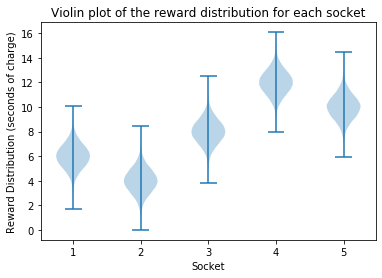

In [7]:
# plot the charge we got from the sockets           
plt.violinplot(rewards)   
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.title('Violin plot of the reward distribution for each socket')
plt.show()

In the "violin" plot above, the line for each socket shows the range of values returned as the reward for each socket. So socket number 1 returned between approximately 2 and 10 seconds of charge. The shaded area, underneath the line, represents the frequency at which each reward was returned. For socket 1 the most frequently returned reward was 6 seconds of charge. This is the mean reward for this socket and also its true reward value.

Text(0, 0.5, 'Density')

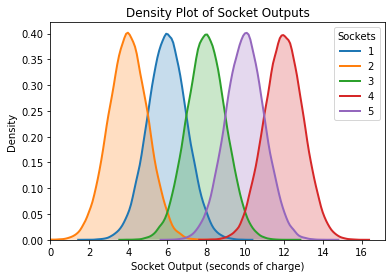

In [8]:
# iterate through the sockets to draw each plot
# (from: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');
    
# Plot formatting
plt.xlim(0, None)
plt.legend(title = 'Sockets')
plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')

In the density plot we can see how the reward probability varies for each socket. Socket number 4 is the best, giving an average of 12 seconds worth of charge, whereas socket 2 is the worst, giving only 4 seconds worth. Socket 4 is the optimal socket that we're trying to find and exploit.

---

# The Socket Tester

We're also going to need a way to sample and select from the set of sockets at each time step. This is handled by the SocketTester class, as shown below:

In [9]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]        
                                                 
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)                        

    def select_socket( self, t ):
        """ choose the socket with the current highest mean reward or arbitrarily
            select a socket in the case of a tie """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run for the defined number of steps """       

        for t in range(number_of_steps):                    
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)

The <i>SocketTester</i> class creates a set of power sockets, with the supplied socket order, as defined previously. When it's run, the socket tester loops for a specified number of time steps and, at each time step, performs the following operations:

<b><i>Select a socket</i>:</b> 

This is done by calling the '<i>sample</i>' function for each socket and then choosing the socket with the largest returned value. As described previously, by default the returned sample value will just be a socket's current estimate of its mean reward.

When there is more than one socket with the highest sample value, the '<i>random_argmax</i>' function (shown below) arbitrarily selects one of the sockets with the largest value. This is used in preference to Numpy's <i>argmax</i> function which simply chooses the first item when a tie occurs.

In [10]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

<b><i>Charge and Update</i>:</b>

Once a socket has been chosen we charge from that socket to get a reward. We then update that socket, incrementing its count of the number of times its been tried and improving its reward estimate using the new reward value.



Note that the code shown above for the 'SocketTester' class is a cut-down version of the actual class and only shows the main functionality. In the full version of the class the properties of the sockets are tracked during the course of the run. Additionally, this class only performs a single run. Since we're dealing with random variables one run may not be sufficient to determine the true behaviour of a socket selection strategy. Therefore a second class, 'SocketExperiment', is used to setup and run repeated socket tests and generate the average results obtained across these tests. The full code for both of these classes can be found in the Github repository.

![](Images/green_babyrobot_small.gif)

---
# Summary

This part of our look at Multi-Armed Bandits didn't really look at them at all! However, it did cover all of the basic framework that we'll need to create and evaluate the Multi-Armed Bandit strategies in the subsequent articles.

In the future articles we'll take the theory we learnt in part 1, and combine it with this test framework, to start examining how the various Bandit strategies can be applied to explore and exploit the set of power sockets.